### @WSS21: Winter-Spring School

Jupyter Notebook Author: Naresh Adhikari

5th Week 20th June 2021


### Bayesian Inference and Analysis 

### Let's import relevant packages.

In [3]:
#import bilby
import numpy as np
import matplotlib.pyplot as plt

### Define a model.

In [4]:
def modelA(time, omega):
    return np.sin(omega*time)

### Simulate data.

In [5]:
sigma = 0.1
omega_true = 1.2
time = np.linspace(0,12,100)
ydet = modelA(time, omega = omega_true)
yobs = ydet + np.random.normal(0,sigma,len(time)) # Observed data = SIGNAL + GAUSSIAN NOISE


### Plot data.

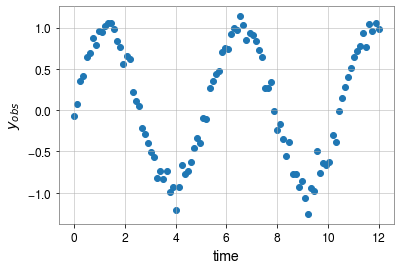

In [6]:
plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

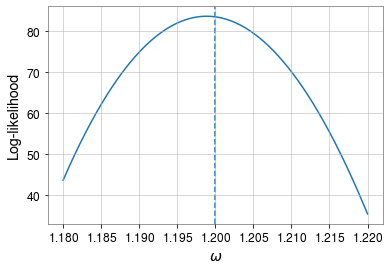

In [7]:
def ln_likelihood(yobs, time, omega, sigma = 0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs-yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

omega_grid = np.linspace(omega_true - 2e-2, omega_true + 2e-2 , 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls = '--')
plt.xlabel("$\omega$");plt.ylabel("Log-likelihood")
plt.show()

    

In [8]:
#ln_likelihood(yobs = yobs,time = time,omega = 1.20, sigma = 0.5)

### Maximum likelihood

In [9]:
#help(np.argmax)

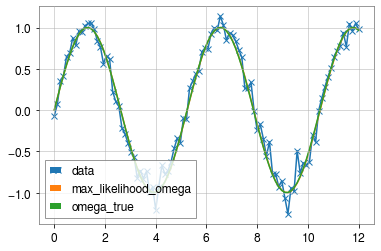

In [10]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x', label = 'data')
plt.plot(time, modelA(time, max_likelihood_omega), label = 'max_likelihood_omega')
plt.plot(time, modelA(time, omega_true), label = 'omega_true')
plt.legend(loc = 'lower left')
plt.show()

In [11]:
max_likelihood_omega

1.198858858858859

#### What is missing in the above graph ? 
Now let's look at the note.

### Normalised posterior density function (pdf)
#### Let's plot the posterior (equal to the likelihood in this case) taking an exponent.

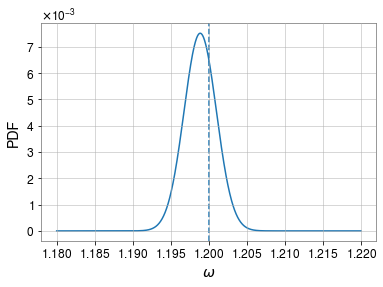

In [12]:
pdf_unnormalized = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--') # vertical line
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()


In [13]:
omega_grid

array([1.18      , 1.18004004, 1.18008008, ..., 1.21991992,
       1.21995996, 1.22      ])

In [14]:
pdf_normalized

array([2.73673562e-20, 3.24964963e-20, 3.85724974e-20, ...,
       1.01731225e-23, 8.48988516e-24, 7.08280249e-24])

### Why is the peak not consistent with the true value?
- Cleary the median of this distribution does not agree with the true value.
- The noise in the observed data means that we have uncertainty !
- How can be quantify this?
- Bayesian answer is the credible interval.
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 95\% probability.
- How do we figure out these numbers?


## Cumulative distribution


$CDF(\omega) = \int_{-\infty}^{\omega}P(\omega'|data) d\omega'$

In [15]:
#help(np.cumsum)


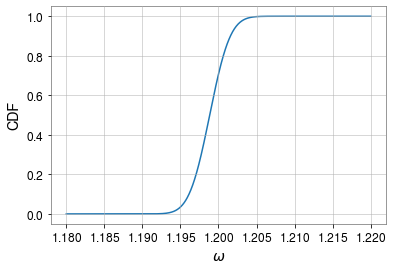

In [16]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

In [17]:
cdf

array([2.73673562e-20, 5.98638524e-20, 9.84363498e-20, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers (such that the interval contains 90% of the probability)


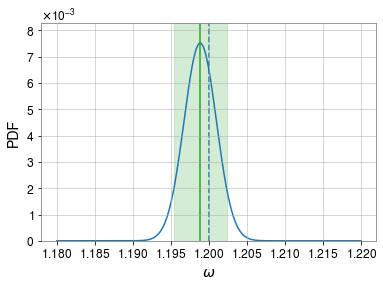

In [18]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized)); plt.xlabel("$\omega$"); plt.ylabel("PDF")
plt.show()

## Let's complicate things.
- In low-dimensions, evaluating a grid of points isn't too crazy
- In high-dimensionl problems, the number of grid points scales with the number of dimensions!
- Here we turn to stochastic sampling algorithms

## Building a peak-finding algorithm.


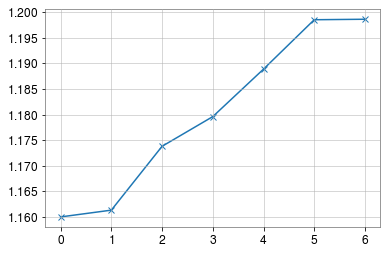

In [19]:
omega_values = [1.16] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
        
plt.plot(omega_values, '-x')
plt.show()

In [20]:
omega_values[0]

1.16

- Good at finding the peak of a unimodel likelihood to arbitrary precision
- Bad if things are multimodal
- Doesn't tell us anything about the "structure"

## Very basic Metropolis-Hastings sampler
### Markov-Chain Monte-Carlo samplers use "randomness" to sample from the posterior distribution



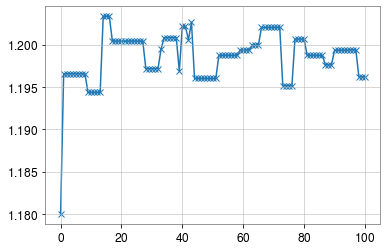

In [21]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

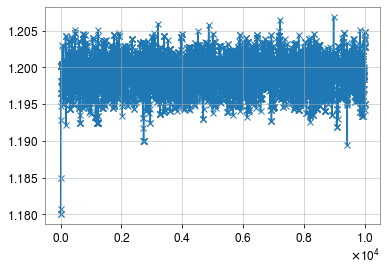

In [22]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(10000):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Histogram the samples

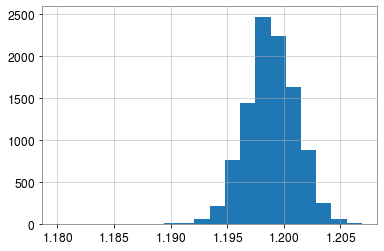

In [23]:

_ = plt.hist(omega_values, bins=20)

### Sampling takeaways
- Stochastic samplers are all about drawing "samples" from the posterior distribution

- Simple MCMC methods need tuning

- Advanced MCMC methods have fewer tuning parameters

- Parallel tempering is required to deal with multi-model distributions
- Can calculate evidences (but not advised).
- Nested Sampling is better than MCMC

- Calculated evidences by design
- Deals well with multimodal distributions

In [24]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform


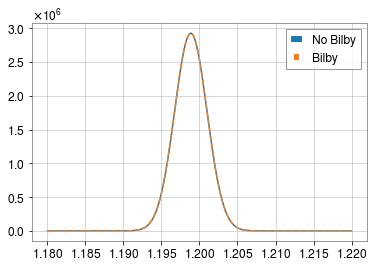

In [25]:
likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelA, sigma=0.1)

ln_likelihood_grid_bilby = []
for omega in omega_grid:
    likelihood.parameters["omega"] = omega
    ln_likelihood_grid_bilby.append(likelihood.log_likelihood())
    
plt.plot(omega_grid, np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid)), label="No Bilby")
plt.plot(omega_grid, np.exp(ln_likelihood_grid_bilby - np.mean(ln_likelihood_grid_bilby)), '--', label="Bilby")
plt.legend()
plt.show()

### Increase complexity

#### Consider model  $y_{B}(t) = A \sin(\omega t + \phi_{0})$
- If we don't know what $\sigma$ is?
- We could repeat the operation above:

- Create a grid (now in 4D)
- Evaluate the likelihood over the grid and find a maximum.

- But the number of grid point we need is $\propto (\textrm{the grid spacing})^N$

### Stochastic Sampling methods



In [26]:
def modelB(time, omega, A, phi0):
    return A * np.sin(omega * time + phi0)

likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelB)

priors = dict(
    A=Uniform(0, 2, "A"),
    omega=Uniform(1, 1.5, "omega"),
    phi0=Uniform(-np.pi, np.pi, "phi0", boundary='reflective'),
    sigma=Uniform(0, 2, "sigma"))

result = bilby.run_sampler(
    likelihood, priors=priors, nlive=500, sample='unif', outdir="test-outdir", label="black-box",
    injection_parameters=dict(A=1, omega=omega_true, phi0=0, sigma=sigma),
    clean=True)

01:22 bilby INFO    : Running for label 'black-box', output will be saved to 'test-outdir'
01:22 bilby INFO    : Search parameters:
01:22 bilby INFO    :   A = Uniform(minimum=0, maximum=2, name='A', latex_label='A', unit=None, boundary=None)
01:22 bilby INFO    :   omega = Uniform(minimum=1, maximum=1.5, name='omega', latex_label='omega', unit=None, boundary=None)
01:22 bilby INFO    :   phi0 = Uniform(minimum=-3.141592653589793, maximum=3.141592653589793, name='phi0', latex_label='phi0', unit=None, boundary='reflective')
01:22 bilby INFO    :   sigma = Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
01:22 bilby INFO    : Single likelihood evaluation took 1.695e-04 s


0it [00:00, ?it/s]

01:22 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1bc1157b10>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
01:22 bilby INFO    : Checkpoint every n_check_point = 4000000
01:22 bilby INFO    : Using dynesty version 1.0.1


9856it [00:17, 700.39it/s, bound:73 nc:3 ncall:38981 eff:25.3% logz=68.53+/-0.25 dlogz:0.102>0.10]    

01:23 bilby INFO    : Writing checkpoint file test-outdir/black-box_resume.pickle



9866it [00:18, 536.06it/s, bound:73 nc:1 ncall:39002 eff:26.6% logz=68.61+/-0.25 dlogz:0.000>0.10]



01:23 bilby INFO    : Sampling time: 0:00:17.019674
01:23 bilby INFO    : Summary of results:
nsamples: 10366
log_noise_evidence:    nan
log_evidence: 68.611 +/-  0.252
log_bayes_factor:    nan +/-  0.252



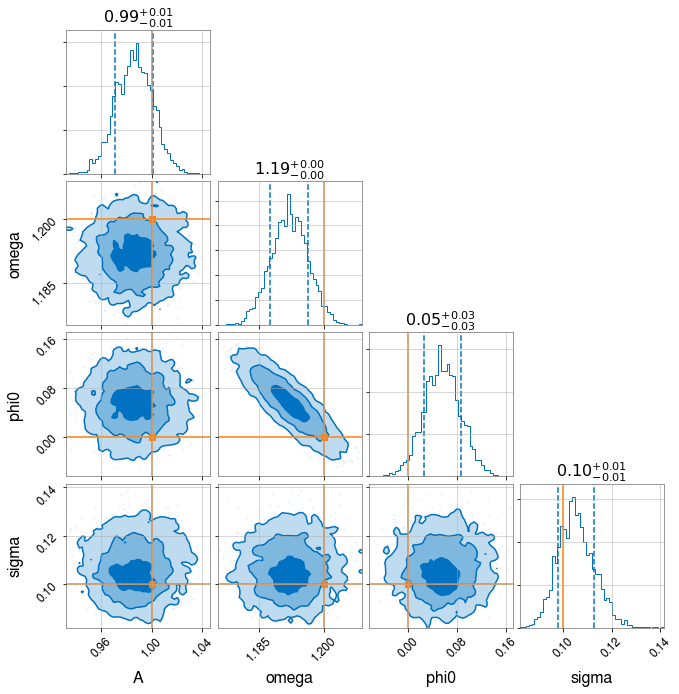

In [27]:
result.plot_corner()


- Bilby has used a Nested Sampling algorithm dynesty to evaluate the posteriors
- The posterior output are a set of samples
- The samples are "points drawn from the posterior distribution"
- Stored in a pandas DataFrame

In [28]:
result.posterior.head()

,A,omega,phi0,sigma,log_likelihood,log_prior
0,0.980624,1.194732,0.102366,0.138394,73.426719,-2.531024
1,1.012980,1.180086,0.165680,0.131753,74.678456,-2.531024
2,0.936447,1.197710,-0.019281,0.122930,75.210836,-2.531024
3,1.021149,1.175206,0.163343,0.106402,75.602592,-2.531024
4,1.020776,1.176972,0.112141,0.117025,75.875781,-2.531024


In [30]:
print(result.outdir) 


/home/naresh/bilby/test-outdir


In [33]:
!ls /home/naresh/bilby/test-outdir


black-box_checkpoint_trace.png	black-box_result.json
black-box_corner.png		black-box_resume.pickle
black-box_dynesty.pickle


In [34]:
!head /home/naresh/bilby/test-outdir/black-box_result.json

{
  "label": "black-box",
  "outdir": "/home/naresh/bilby/test-outdir",
  "sampler": "dynesty",
  "log_evidence": 68.61146137162905,
  "log_evidence_err": 0.25159531300908294,
  "log_noise_evidence": NaN,
  "log_bayes_factor": NaN,
  "priors": {
    "A": {


In [36]:
result_loaded = bilby.result.read_in_result("test-outdir/black-box_result.json")


In [43]:
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)  # In seconds
print(result.version)

68.61146137162905
{'A': 1, 'omega': 1.2, 'phi0': 0, 'sigma': 0.1}
17.019674
bilby=0.6.1:


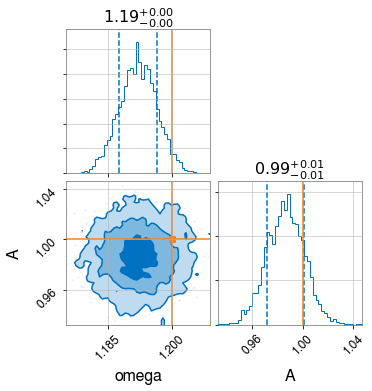

In [44]:
result.plot_corner(dict(omega=omega_true, A=1))


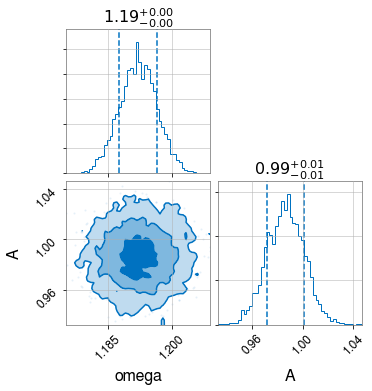

In [45]:
result.plot_corner(['omega', 'A'])


In [47]:
likelihood.parameters


{'omega': 1.1926700579051128,
 'A': 0.9841986582457785,
 'phi0': 0.06082344808060558,
 'sigma': 0.10508036266748273}

In [48]:
# result.plot_marginals(['omega'], priors=True)


# References:

- GregoryAshton: Inference- Data analysis hands on training.